## Analyze A/B Test Results
## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [4]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [5]:
(df.query('converted == "1"')['user_id'].nunique()/df['user_id'].nunique())*100


12.104245244060237

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
#treatment group user on old_page 
treat_old = df.query("group == 'treatment' and landing_page == 'old_page'")
#control group user on new_page
ctrl_new = df.query("group == 'control' and landing_page == 'new_page'")
#number of times the new_page and treatment don't line up is sum of above two values
treat_old['user_id'].count()+ctrl_new['user_id'].count()

3893

f. Do any of the rows have missing values?

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  
We should only use the rows that we can feel confident in the accuracy of the data, so we shoud remove this rows.

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
#drop rows where treatment is not aligned with new_page
df.drop(df.query("group == 'treatment' and landing_page == 'old_page'").index, inplace=True)
#drop rows where control is not aligned with old_page
df.drop(df.query("group == 'control' and landing_page == 'new_page'").index, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290585 entries, 0 to 294477
Data columns (total 5 columns):
user_id         290585 non-null int64
timestamp       290585 non-null object
group           290585 non-null object
landing_page    290585 non-null object
converted       290585 non-null int64
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


In [9]:
# save new cleaned dataset
df.to_csv('ab_cleaned.csv', index=False)
#read new dataset in new dataframe df2
df2 = pd.read_csv('ab_cleaned.csv')

In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [11]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [12]:
df2['user_id'].duplicated().sum()

1

c. What is the row information for the repeat **user_id**? 

In [13]:
df2[df2.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted
1876,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2862,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [14]:
#remove first duplicate, remain last
df2 = df2.drop_duplicates(['user_id'], keep='last')
df2[df2.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted


In [15]:
#check if one duplicate is gone
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 0 to 290584
Data columns (total 5 columns):
user_id         290584 non-null int64
timestamp       290584 non-null object
group           290584 non-null object
landing_page    290584 non-null object
converted       290584 non-null int64
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [16]:
#Given that all the values are either 1 or 0, the mean will be the number of 1's divided by the total number of rows.
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [17]:
df_ctrl = df2[df2['group'] == 'control']
df_ctrl['converted'].mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [18]:
df_treat = df2[df2['group'] == 'treatment']
df_treat['converted'].mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [19]:
#individual received the new page is in line with treatment group
#length of treatment group = number of users received the new page
new_page_users = len(df_treat)
#total number of users
users = len(df2)  
#probability that an individual received the new page 
new_page_users/users

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

**Consider above results we can conclude that there is no sufficient evidence to say that the new treatment page leads to more conversions. Probability that an individual received the new page is 0.5, while probability of an individual converting regardless of the page they receive 0.12. And for an individuals in the `control` group and `treatment` group the difference between probabilities that they converted is not sufficient for making decisions. For `control` group and an old page this probability is slightly better(0.1203863 against 0.1188081 for the new page). And we should admit that the performance for both pages is close to overall performance 0.12 regardless of the page.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Hypotheses:
  Null: the old page is better.
  Alternative: the new page is better.**  
   $H_{0}$ : $p_{new}$ <= $p_{old}$ ,
   $H_{1}$ : $p_{new}$ > $p_{old}$
   

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [20]:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [21]:
p_old = df2['converted'].mean()
p_old

0.11959708724499628

c. What is $n_{new}$?

In [22]:
n_new = len(df2.query("group == 'treatment'"))
n_new

145310

d. What is $n_{old}$?

In [23]:
n_old = len(df2.query("group == 'control'"))
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [24]:
#new_page_converted = np.random.choice([1, 0], size=n_new, p=[p_new, (1-p_new)])
#len(new_page_converted)
new_page_converted=np.random.binomial(n_new,p_new)

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [25]:
#old_page_converted = np.random.choice([1, 0], size=n_old, p=[p_old, (1-p_old)])
#len(old_page_converted)
old_page_converted=np.random.binomial(n_old,p_old)

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [26]:
#len(new_page_converted)-len(old_page_converted)

In [27]:
#operands could not be broadcast together with shapes (145310,) (145274,), so we resize new_page_converted to 145274
#new_page_converted = new_page_converted[:145274]

In [28]:
p_diff = (new_page_converted/n_new) - (old_page_converted/n_old)
p_diff

-0.00030503740891014985

Here we are looking at a null where there is no difference in conversion based on the page, which means the conversions for each page are the same

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [29]:
#mean function to overcome shape difference
p_diffs = []
for _ in range(10000):
    old_page_converted = np.random.binomial(n_old,p_old)
    new_page_converted=np.random.binomial(n_new,p_new)
    p_diffs.append((new_page_converted/n_new) - (old_page_converted/n_old))

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

Text(0.5,1,'Plot of 10,000 simulated p_diffs')

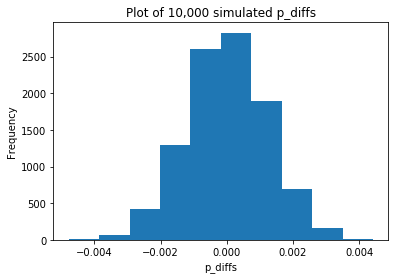

In [30]:
plt.hist(p_diffs)
plt.xlabel('p_diffs')
plt.ylabel('Frequency')
plt.title('Plot of 10,000 simulated p_diffs')

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [31]:
#actual difference from ab_data.csv
act_diff = df[df['group'] == 'treatment']['converted'].mean() -  df[df['group'] == 'control']['converted'].mean()
act_diff 

-0.0015790565976871451

In [32]:
p_diffs = np.array(p_diffs)
p_diffs

array([ -8.46156272e-05,  -9.10596591e-04,   1.32644442e-03, ...,
        -1.44759831e-03,  -7.52344995e-04,   9.96039419e-04])

In [33]:
(act_diff < p_diffs).mean()

0.90390000000000004

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**We compute p-value. This is the probability of observing our statistic (or one more extreme in favor of the alternative) if the null hypothesis is true. We have large p-value (> 0.05) that indicates weak evidence against the null hypothesis, so we fail to reject the null hypothesis. Actually, the new page conversion rate is even slightly worse than old.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [34]:
import statsmodels.api as sm

convert_old = sum(df2.query("group == 'control'")['converted'])
convert_new = sum(df2.query("group == 'treatment'")['converted'])
n_old = len(df2.query("group == 'control'"))
n_new = len(df2.query("group == 'treatment'"))
  
convert_old, convert_new, n_old, n_new

/Users/oleksandranikiiev/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


(17489, 17264, 145274, 145310)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [35]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
z_score, p_value

(1.3109241984234394, 0.90505831275902449)

In [36]:
from scipy.stats import norm
# Tells us how significant our z-score is
norm.cdf(z_score), norm.ppf(1-(0.05))# Tells us what our critical value at 95% confidence is

(0.90505831275902449, 1.6448536269514722)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Since the z-score of 1.3109241984234394 not exceeds the critical value of 1.6448536269514722, we fail to reject the null hypothesis ( $H_{0}$ : $p_{new}$ <= $p_{old}$ ). We have the same large p-value (0.9 > 0.05) that indicates weak evidence against the null hypothesis.  Old page is not statistically different and better than new page. This align with previous results in parts j and k.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic regression (because we have binary outcome).**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [41]:
df2['intercept']=1
df2[['control', 'treatment']] = pd.get_dummies(df2['group'])
#we can drop control column and use only treatment column as ab_page
#df.drop
#df.rename
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,control,treatment
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [42]:
import statsmodels.api as sm
logit = sm.Logit(df2['converted'],df2[['intercept','treatment']])


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [43]:
results = logit.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Wed, 07 Feb 2018   Pseudo R-squ.:               8.077e-06
Time:                        13:45:09   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
treatment     -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**P-value is 0.19. It differs from the value found in part II because this is two-sided test (and in Part II was one-sided) and our hypotesis here:  $H_{0}$ : $p_{new}$ - $p_{old}$  = 0, 
$H_{1}$ : $p_{new}$ - $p_{old}$  != 0.**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

** Other things that might influence whether or not an individual converts: user's country, user's age, if it's new user or not, novelty effect, change aversion, seasonality or dependance from time of day or weekday/weekend. Here we have small enough data range (just 1 month) to see any seasonality. The disadvantages of adding additional terms into the regression model is that even with additional factors we can never account for all influencing factors or accomodate them. And the more metrics we evaluate, the more likely we observe significant differences. We need to use corrections methods in this case. And we can have Sympson's paradox in action. **

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [44]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,control,treatment
user_id,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1


In [45]:
#df_new(['country']).value_counts()

In [46]:
### Create the necessary dummy variables, 2 of 3
df_new[['CA', 'UK']] = pd.get_dummies(df_new['country'])[['CA','UK']]
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,control,treatment,CA,UK
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1,0,1


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [51]:
### Fit Your Linear Model And Obtain the Results
#df['intercept'] = 1
log_mod = sm.Logit(df_new['converted'], df_new[['intercept','treatment','CA', 'UK']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Wed, 07 Feb 2018   Pseudo R-squ.:               2.323e-05
Time:                        14:05:56   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
treatment     -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

In this model we look at an interaction between page and country to see if there significant effects on conversion. We find out that the values do not show a substantial difference in the conversion rates depending on countries, and the convertion rate is even a little bit worse for a new page. This indicates that we can accept the Null Hypothesis and keep the existing page as in previous findings.

<a id='conclusions'></a>
## Conclusions

Using Probability, A/B test and Regression, we found out that the performance of the old page is almost the same(even a little bit better) than a new page. We accept the Null Hypothesis and Reject the Alternate Hypothesis. This analysis have some limitations due to factors not included in the data and mentioned in part IIIf.

## Resources:

1.https://www.youtube.com/watch?v=7FTp9JJ5DfE&feature=youtu.be
2.https://udacitydatascience.slack.com/messages/C6STPDFU4/files/F8RKY5WUV/ <br/>
3.https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html


### Gather Submission Materials

Once you are satisfied with the status of your Notebook, you should save it in a format that will make it easy for others to read. You can use the __File -> Download as -> HTML (.html)__ menu to save your notebook as an .html file. If you are working locally and get an error about "No module name", then open a terminal and try installing the missing module using `pip install <module_name>` (don't include the "<" or ">" or any words following a period in the module name).

You will submit both your original Notebook and an HTML or PDF copy of the Notebook for review. There is no need for you to include any data files with your submission. If you made reference to other websites, books, and other resources to help you in solving tasks in the project, make sure that you document them. It is recommended that you either add a "Resources" section in a Markdown cell at the end of the Notebook report, or you can include a `readme.txt` file documenting your sources.

### Submit the Project

When you're ready, click on the "Submit Project" button to go to the project submission page. You can submit your files as a .zip archive or you can link to a GitHub repository containing your project files. If you go with GitHub, note that your submission will be a snapshot of the linked repository at time of submission. It is recommended that you keep each project in a separate repository to avoid any potential confusion: if a reviewer gets multiple folders representing multiple projects, there might be confusion regarding what project is to be evaluated.

It can take us up to a week to grade the project, but in most cases it is much faster. You will get an email once your submission has been reviewed. If you are having any problems submitting your project or wish to check on the status of your submission, please email us at dataanalyst-project@udacity.com. In the meantime, you should feel free to continue on with your learning journey by beginning the next module in the program.

In [44]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0